<a href="https://colab.research.google.com/github/tasnimislamraisa/Python_Learning/blob/deep-Learning/Multimodal_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install -q transformers torchvision scikit-learn


In [39]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [40]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


# **Set dataset paths in Colab**

In [41]:
BASE_DIR = "/content/drive/MyDrive/FakeNews_Multimodal_Dataset/fakeddit_subset"

TRAIN_JSON = f"{BASE_DIR}/training_data_fakeddit.jsonl"
VAL_JSON   = f"{BASE_DIR}/validation_data_fakeddit.jsonl"

TRAIN_IMG_DIR = f"{BASE_DIR}/image_folder"
VAL_IMG_DIR   = f"{BASE_DIR}/validation_image"


In [42]:
import os

print(os.path.exists(TRAIN_JSON))
print(os.path.exists(VAL_JSON))
print(len(os.listdir(TRAIN_IMG_DIR)))
print(len(os.listdir(VAL_IMG_DIR)))


True
True
4000
4210


# **Load JSON files**

In [43]:

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

train_df = load_jsonl(TRAIN_JSON)
val_df   = load_jsonl(VAL_JSON)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
train_df.head()


Train size: 4000
Val size: 4210


,contents
0,"[{'role': 'user', 'parts': [{'fileData': {'mim..."
1,"[{'role': 'user', 'parts': [{'fileData': {'mim..."
2,"[{'role': 'user', 'parts': [{'fileData': {'mim..."
3,"[{'role': 'user', 'parts': [{'fileData': {'mim..."
4,"[{'role': 'user', 'parts': [{'fileData': {'mim..."


In [44]:
train_df.columns


Index(['contents'], dtype='object')

In [45]:
train_df.iloc[0]['contents']


[{'role': 'user',
  'parts': [{'fileData': {'mimeType': 'image/jpeg',
     'fileUri': 'gs://my_trial_bucket_finetune/image_folder/9a46c1362ec06f0ffbd2578fa777ea8d.jpg'}},
   {'text': 'Title:"he cut some tomatoes and put them in a bucket what happened days later made me so jealous"\n\nis the picture and title indicate that this is from a fake news? (Only Answer "Yes"/"No")'}]},
 {'role': 'model', 'parts': [{'text': 'Yes'}]}]

In [46]:
def extract_sample(sample):
    user = sample[0]
    model = sample[1]

    # Extract image
    image_path = None
    text = None

    for part in user['parts']:
        if 'fileData' in part:
            image_path = part['fileData']['fileUri'].split('/')[-1]
        if 'text' in part:
            text = part['text']

    # Extract label
    label_text = model['parts'][0]['text']
    label = 1 if label_text.lower() == 'yes' else 0  # 1=fake, 0=real

    return image_path, text, label


In [47]:
train_df.iloc[0]['contents']


[{'role': 'user',
  'parts': [{'fileData': {'mimeType': 'image/jpeg',
     'fileUri': 'gs://my_trial_bucket_finetune/image_folder/9a46c1362ec06f0ffbd2578fa777ea8d.jpg'}},
   {'text': 'Title:"he cut some tomatoes and put them in a bucket what happened days later made me so jealous"\n\nis the picture and title indicate that this is from a fake news? (Only Answer "Yes"/"No")'}]},
 {'role': 'model', 'parts': [{'text': 'Yes'}]}]

In [48]:
def parse_contents(df):
    records = []

    for row in df['contents']:
        user_part = row[0]
        model_part = row[1]

        image = None
        text = None

        for part in user_part['parts']:
            if 'fileData' in part:
                image = part['fileData']['fileUri'].split('/')[-1]
            if 'text' in part:
                text = part['text']

        label_text = model_part['parts'][0]['text'].strip().lower()
        label = 1 if label_text == "yes" else 0  # Fake=1, Real=0

        if image and text:
            records.append({
                "image": image,
                "text": text,
                "label": label
            })

    return pd.DataFrame(records)


In [49]:
train_clean = parse_contents(train_df)
val_clean   = parse_contents(val_df)

print(train_clean.columns)
train_clean.head()


Index(['image', 'text', 'label'], dtype='object')


,image,text,label
0,9a46c1362ec06f0ffbd2578fa777ea8d.jpg,"Title:""he cut some tomatoes and put them in a ...",1
1,18bb4fa9fd1dfc1fd318887c997a01d5.jpg,"Title:""crazy tennis face ripe for the photosho...",0
2,44ac90bced0683e03379f63adac4317a.jpg,"Title:""spicy vitamin water exists""\n\nis the p...",0
3,083a2d024bdf06b0325218d1e245365f.jpg,"Title:""football helmet tester""\n\nis the pictu...",0
4,06c144d8c17c8bf0457718ccdbc0ddf9.jpg,"Title:""shoryuken""\n\nis the picture and title ...",1


In [50]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_clean['label'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
print("Class weights:", class_weights)


Class weights: tensor([0.8730, 1.1703], device='cuda:0')


In [51]:
train_clean['label'].value_counts()
train_clean[['image', 'text']].head()


,image,text
0,9a46c1362ec06f0ffbd2578fa777ea8d.jpg,"Title:""he cut some tomatoes and put them in a ..."
1,18bb4fa9fd1dfc1fd318887c997a01d5.jpg,"Title:""crazy tennis face ripe for the photosho..."
2,44ac90bced0683e03379f63adac4317a.jpg,"Title:""spicy vitamin water exists""\n\nis the p..."
3,083a2d024bdf06b0325218d1e245365f.jpg,"Title:""football helmet tester""\n\nis the pictu..."
4,06c144d8c17c8bf0457718ccdbc0ddf9.jpg,"Title:""shoryuken""\n\nis the picture and title ..."


In [52]:
train_clean.head()
train_clean['label'].value_counts()


,count
label,
0,2291
1,1709


In [53]:
print(train_clean.columns)


Index(['image', 'text', 'label'], dtype='object')


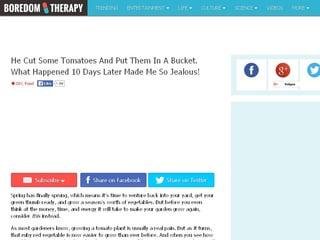

In [54]:
Image.open(os.path.join(TRAIN_IMG_DIR, train_clean.iloc[0]['image']))


In [55]:
class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ---------- TEXT ----------
        encoding = self.tokenizer(
            row['text'],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        # ---------- IMAGE (SAFE LOAD) ----------
        img_path = os.path.join(self.image_dir, row['image'])

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            # 🔴 Fallback: use blank image
            image = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'image': image,
            'label': label
        }


**snopes_medical data**

# **Load and inspect the dataset**

***Clean & preprocess***

# **Train–Validation Split**

In [56]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = MultimodalDataset(train_clean, TRAIN_IMG_DIR, tokenizer)
val_dataset   = MultimodalDataset(val_clean, TRAIN_IMG_DIR, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [57]:
class MultimodalFakeNewsModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")
        self.image_encoder = models.resnet18(pretrained=True)

        self.image_encoder.fc = nn.Linear(512, 256)
        self.text_fc = nn.Linear(768, 256)

        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, image, input_ids, attention_mask):
        text_features = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).pooler_output

        text_features = self.text_fc(text_features)
        image_features = self.image_encoder(image)

        fused = torch.cat((text_features, image_features), dim=1)
        return self.classifier(fused)


In [58]:
model = MultimodalFakeNewsModel().to(DEVICE)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# STEP 1: Freeze all BERT layers
for param in model.text_encoder.parameters():
    param.requires_grad = False

# STEP 2: Unfreeze ONLY the last BERT layer
for param in model.text_encoder.encoder.layer[-1].parameters():
    param.requires_grad = True


# **Training Loop**

In [70]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)




In [71]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable:,}")
print(f"Total params:     {total:,}")


Trainable params: 18,593,602
Total params:     120,987,970


In [72]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [73]:
train_dataset = MultimodalDataset(
    train_clean, tokenizer, TRAIN_IMG_DIR, transform
)

val_dataset = MultimodalDataset(
    val_clean, tokenizer, VAL_IMG_DIR, transform
)


In [74]:
def train_epoch(model, loader):
    model.train()
    total_loss, correct = 0, 0

    for batch in tqdm(loader):
        optimizer.zero_grad()

        outputs = model(
            batch['image'].to(DEVICE),
            batch['input_ids'].to(DEVICE),
            batch['attention_mask'].to(DEVICE)
        )

        loss = criterion(outputs, batch['label'].to(DEVICE))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == batch['label'].to(DEVICE)).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


In [75]:
def eval_epoch(model, loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                batch['image'].to(DEVICE),
                batch['input_ids'].to(DEVICE),
                batch['attention_mask'].to(DEVICE)
            )

            loss = criterion(outputs, batch['label'].to(DEVICE))
            total_loss += loss.item()
            correct += (outputs.argmax(1) == batch['label'].to(DEVICE)).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


# **Train Model**

In [76]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [77]:
best_val_acc = 0
patience = 2
counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break


100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Early stopping triggered


In [78]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                batch['image'].to(DEVICE),
                batch['input_ids'].to(DEVICE),
                batch['attention_mask'].to(DEVICE)
            )

            preds = outputs.argmax(1).cpu().numpy()
            labels = batch['label'].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    print("Classification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=["Real", "Fake"],
        digits=4
    ))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


In [68]:
model.load_state_dict(torch.load("best_model.pt"))
evaluate_model(model, val_loader)


Classification Report:
              precision    recall  f1-score   support

        Real     0.7895    0.8557    0.8212      2349
        Fake     0.7963    0.7120    0.7518      1861

    accuracy                         0.7922      4210
   macro avg     0.7929    0.7838    0.7865      4210
weighted avg     0.7925    0.7922    0.7905      4210

Confusion Matrix:
[[2010  339]
 [ 536 1325]]
